# Amazon Fine Food Review Analysis using Logistic Regression

In [3]:
%matplotlib inline

import sqlite3
import pandas as pd
import seaborn as sn
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect('final.sqlite') 

In [5]:
data = pd.read_sql_query("""SELECT * FROM Reviews""", con)
labels_count = data['Score'].value_counts()
#labels = sorted_data['Score']
print(labels_count)

positive    307061
negative     57110
Name: Score, dtype: int64


In [6]:
# TIme based sorting
sorted_data=data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
labels = sorted_data['Score']
print(labels.shape)
print(sorted_data.shape)

(364171,)
(364171, 12)


In [7]:
sorted_data.head()         # Time is in ascending order which means the dataset is of Time Based slicing.

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [8]:
sorted_data['CleanedText'][0]

b'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'

# Bag of Words

In [9]:
sample_data = sorted_data.sample(n=100000)
print(sample_data.shape)
sample_labels = sample_data['Score']
print(sample_labels.shape)

(100000, 12)
(100000,)


In [98]:
sample_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
334349,313505,339442,B005A1LJ04,A24O15MYDNLZBE,"Lori Smart ""Amazon Queen""",0,0,positive,1326844800,Sugar Free Margarita Mocktail,These Crystal Light Mocktails are fantastic su...,b'crystal light mocktail fantast summeri treat...
320870,266335,288700,B004Q4AQDW,A7E85LH2I0TAP,"a metaphysician ""of erudition""",0,0,positive,1321056000,One of the best...,"One of my 3 favorite, flavored black teas. I ...",b'one favorit flavor black tea cant begin desc...
118810,265412,287701,B000SARZ46,A1H8RBIVE73JSB,Happy mom,2,2,positive,1238630400,YUMMY,"My son has multiple allergies, he's allergic t...",b'son multipl allergi hes allerg wheat egg nut...
133894,96036,104365,B000YSRK7E,AWH2AY17ZU7W2,Jesse Baynard,0,0,positive,1220486400,Very good tortilla chips,The taste of these is right between Tostitos M...,b'tast right tostito multigrain chip origin su...
280016,360595,390004,B003PEKJK4,A3QODWMRMV3XNE,Joy O. Williams,9,9,positive,1317600000,Best. Cinnamon. Ever.,Though Kirkland's is not as good as some other...,b'though kirkland good vietnames cinnamon ive ...


In [11]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(sample_data['CleanedText'].values)

In [12]:
standardized_data = StandardScaler(with_mean=False).fit_transform(final_counts)

In [13]:
print(standardized_data.shape)
print(sample_labels.shape)

(100000, 38380)
(100000,)


# Train, CV and Test -  BOW

In [14]:
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(standardized_data, sample_labels, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

In [23]:
C_Val = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_scores = []
for val in C_Val:
    Log_reg = LogisticRegression(C=val)
    scores = cross_val_score(Log_reg, X_tr, y_tr, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
print(cv_scores)

[0.90899973268789958, 0.89826515117084926, 0.8778775500191246, 0.8580205152734024, 0.84759203540532402, 0.84689797040773873, 0.84887770387594252]


In [24]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
# determining best lambda
optimal_lambda = C_Val[MSE.index(min(MSE))]
print('\nThe optimal number of lambda is %f.' % optimal_lambda)


The optimal number of lambda is 0.001000.


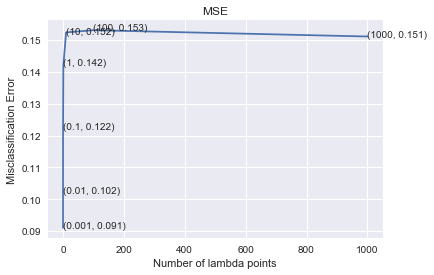

the misclassification error for each lambda is :  [ 0.091  0.102  0.122  0.142  0.152  0.153  0.151]


In [25]:
# plot misclassification error vs alpha 
plt.plot(C_Val, MSE)

for xy in zip(C_Val, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of lambda points')
plt.ylabel('Misclassification Error')
plt.title('MSE')
plt.show()

print("the misclassification error for each lambda is : ", np.round(MSE,3))

In [22]:
# instantiate learning model k = optimal_k
optimal_lambda = 0.001000
log_reg_optimal = LogisticRegression(C=optimal_lambda)

# fitting the model
log_reg_optimal.fit(X_tr, y_tr)

# predict the response
pred = log_reg_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (optimal_lambda, acc))


The accuracy of the Logistic Regression for C = 0.001000 is 91.183333%


# GridSearch - BOW

In [27]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(X_tr, y_tr)
print(model.best_estimator_)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [28]:
print(model.score(X_test, y_test))

0.896666666667


Report:
    The optimal lambda when used GridSearchCV with L2 regularizer is 0.0001 and the accuracy is 89%

In [20]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model_grid_l1 = GridSearchCV(LogisticRegression(penalty='l1',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_grid_l1.fit(X_tr, y_tr)
print(model_grid_l1.best_estimator_)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [21]:
print(model_grid_l1.score(X_test, y_test))

0.9085


Report:
    The optimal lambda when used GridSearchCV with L1 regularizer is 0.0001 and the accuracy is 90.85%

# RandomSearchCV - BOW

In [23]:
mu, sigma = 0, 1
s = np.random.normal(mu, sigma, 10)
#print(s)
from scipy.stats import uniform
uniform.rvs(size=10)

array([ 0.16351342,  0.52477133,  0.68842066,  0.64301038,  0.7576488 ,
        0.68562934,  0.81814153,  0.73435129,  0.87159898,  0.7791563 ])

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
tuned_parameters = {'C': uniform.rvs(size=10)}
model_rand_l2 = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model_rand_l2.fit(X_tr, y_tr)
print(model_rand_l2.best_estimator_)

LogisticRegression(C=0.0025899498542613086, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [25]:
print(model_rand_l2.score(X_test, y_test))

0.905333333333


In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
tuned_parameters = {'C': uniform.rvs(size=10)}
model_rand_l1 = RandomizedSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5,n_jobs=-1)
model_rand_l1.fit(X_tr, y_tr)

In [28]:
print(model_rand_l1.best_estimator_)

LogisticRegression(C=0.07652106455941643, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [27]:
print(model_rand_l1.score(X_test, y_test))

0.879366666667


# Sparsity with L1 BOW

In [30]:
import numpy as np

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(X_tr, y_tr);
print(clf.score(X_test,y_test))

0.906233333333


In [31]:
w = clf.coef_
print(np.count_nonzero(w))

8342


In [34]:
clf = LogisticRegression(C=1, penalty='l1');
clf.fit(X_tr, y_tr);
print('accuracy',clf.score(X_test,y_test))
w = clf.coef_
print('non zero', np.count_nonzero(w))

accuracy 0.876933333333
non zero 10184


In [32]:
clf = LogisticRegression(C=100, penalty='l1');
clf.fit(X_tr, y_tr);
print(clf.score(X_test,y_test))

0.847233333333


In [33]:
w = clf.coef_
print(np.count_nonzero(w))

13921


# Multicollinearity - BOW

* Training the matrix afer adding the noise

In [15]:
# Adding Noise to the matrix
mu, sigma = 0, 0.1
s = np.random.normal(mu, sigma, 1)
print(s)

[ 0.05093885]


In [18]:
noise_matrix = standardized_data*s[0]

In [19]:
# split the data set into train and test
X_1_bow, X_test_bow, y_1_bow, y_test_bow = cross_validation.train_test_split(noise_matrix, sample_labels, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_tr_bow, X_cv_bow, y_tr_bow, y_cv_bow = cross_validation.train_test_split(X_1_bow, y_1_bow, test_size=0.3)

In [20]:
# instantiate learning model k = optimal_k
optimal_lambda_multi = 0.001000 # taken from the above outcome from train,cv and test
log_reg_mutli = LogisticRegression(C=optimal_lambda_multi) 

# fitting the model
log_reg_mutli.fit(X_tr_bow, y_tr_bow)

# predict the response
pred = log_reg_mutli.predict(X_test_bow)

# evaluate accuracy
acc_multi = accuracy_score(y_test_bow, pred) * 100
print('\nThe accuracy of the Logistic Regression after adding noise to the data for C = %f is %f%%' % (optimal_lambda_multi, acc_multi))


The accuracy of the Logistic Regression after adding noise to the data for C = 0.001000 is 84.630000%


In [21]:
weight_multi = log_reg_mutli.coef_ # weights with  noise
print(weight_multi.shape)
print(weight_multi)

(1, 38380)
[[ 0.001678    0.          0.         ...,  0.00230258  0.          0.        ]]


In [24]:
# Weights from the original matrix which is not added any noise
original_weights = log_reg_optimal.coef_ # original weights with no noise
print(original_weights.shape)
print(original_weights)

(1, 38380)
[[ 0.00108222  0.          0.         ...,  0.          0.          0.        ]]


In [25]:
diffs = weight_multi - original_weights
print(diffs.flatten()[:10])

[ 0.00059578  0.          0.          0.          0.00182784  0.0019195
  0.00264413  0.0019195   0.00250729  0.00243956]


# Feature Importance - BOW

In [99]:
abs_weights = np.abs(original_weights)
weights_np = np.asarray(abs_weights).flatten()
print(weights_np.shape)
# get the sorting indices
sorted_index = np.argsort(weights_np)[::-1]
print(sorted_index)

(38380,)
[14416 19589  3116 ...,  8348 21975 38379]


In [100]:
# check if the sorting indices are correct
#flatten_abs_weigths = abs_weights.flatten()
print(weights_np[sorted_index])

[ 0.42384026  0.34710108  0.2762774  ...,  0.          0.          0.        ]


In [101]:

# get the index of the top-10 features
top_10 = sorted_index[:10]
top_f = np.asarray(top_10)
print(top_f)

[14416 19589  3116 14101  9341  8692 24935 11331 11831 22592]


In [102]:
# get the names of the top 2 most important features
feature_names = count_vect.get_feature_names()
#print(feature_names[top_2])
f = np.asarray(feature_names)
print(f[top_f])

['great' 'love' 'best' 'good' 'disappoint' 'delici' 'perfect' 'excel'
 'favorit' 'nice']


# TF-IDF

In [220]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1))
final_tf_idf = tf_idf_vect.fit_transform(sample_data['Text'].values)
print(final_tf_idf.shape)

(100000, 61762)


In [221]:
standardized_data_tf = StandardScaler(with_mean=False).fit_transform(final_tf_idf)
print(standardized_data_tf.shape)

(100000, 61762)


# Train,CV,Test - TFIDF

In [115]:
# split the data set into train and test
X_1_tf, X_test_tf, y_1_tf, y_test_tf = cross_validation.train_test_split(standardized_data_tf, sample_labels, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_tr_tf, X_cv_tf, y_tr_tf, y_cv_tf = cross_validation.train_test_split(X_1_tf, y_1_tf, test_size=0.3)

In [241]:
C_Val = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_scores_tf_idf = []
for val in C_Val:
    Log_reg_tf_idf = LogisticRegression(C=val)
    scores_tf = cross_val_score(Log_reg_tf_idf, X_tr_tf, y_tr_tf, cv=10, scoring='accuracy')
    cv_scores_tf_idf.append(scores_tf.mean())
print(cv_scores_tf_idf)

[0.90134681473110179, 0.88316310318829072, 0.86122431443275449, 0.84442827469165527, 0.83542842015911101, 0.83338758709805583, 0.83293862415064512]


In [243]:
# changing to misclassification error
MSE_tf = [1 - x for x in cv_scores]

# determining best k
optimal_aplha_tf = C_Val[MSE_tf.index(min(MSE_tf))]
print('\nThe optimal number of alpha is %d.' % optimal_aplha_tf)


The optimal number of alpha is 1000.


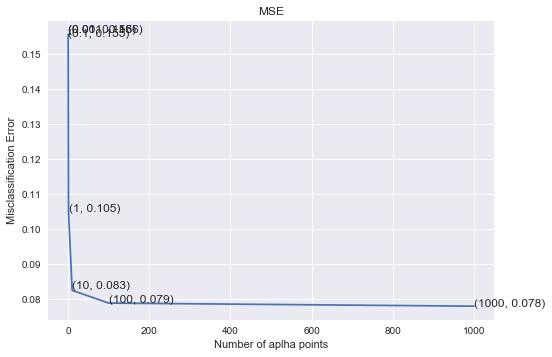

the misclassification error for each alpha is :  [ 0.156  0.156  0.155  0.105  0.083  0.079  0.078]


In [244]:
# plot misclassification error vs alpha 
plt.plot(C_Val, MSE_tf)

for xy in zip(C_Val, np.round(MSE_tf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of aplha points')
plt.ylabel('Misclassification Error')
plt.title('MSE')
plt.show()

print("the misclassification error for each alpha is : ", np.round(MSE_tf,3))

In [116]:
# instantiate learning model k = optimal_k
optimal_aplha_tf=1000
log_reg_optimal_tf = LogisticRegression(C=optimal_aplha_tf)

# fitting the model
log_reg_optimal_tf.fit(X_tr_tf, y_tr_tf)

# predict the response
pred_tf = log_reg_optimal_tf.predict(X_test_tf)

# evaluate accuracy
acc_tf = accuracy_score(y_test_tf, pred_tf) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (optimal_aplha_tf, acc_tf))


The accuracy of the Logistic Regression for C = 1000.000000 is 83.273333%


# GridSearch TF-IDF

In [220]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model_tf = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'accuracy', cv=5)
model_tf.fit(X_tr_tf, y_tr_tf)
print(model_tf.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [221]:
print(model_tf.score(X_test_tf, y_test_tf))

0.916433333333


In [223]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model_tf_l1 = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'accuracy', cv=5)
model_tf_l1.fit(X_tr_tf, y_tr_tf)
print(model_tf_l1.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [224]:
print(model_tf_l1.score(X_test_tf, y_test_tf))

0.916633333333


# RandomSearchCV TF-IDF

In [225]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
tuned_parameters = {'C': uniform.rvs(size=10)}
model_rand_l2_tf = RandomizedSearchCV(LogisticRegression(n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_rand_l2_tf.fit(X_tr_tf, y_tr_tf)
print(model_rand_l2_tf.best_estimator_)

LogisticRegression(C=0.91361595715910737, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [226]:
print(model_rand_l2_tf.score(X_test_tf, y_test_tf))

0.9157


In [227]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
tuned_parameters = {'C': uniform.rvs(size=10)}
model_rand_l1_tf = RandomizedSearchCV(LogisticRegression(penalty='l1',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_rand_l1_tf.fit(X_tr_tf, y_tr_tf)
print(model_rand_l1_tf.best_estimator_)

LogisticRegression(C=0.96431769798190548, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [228]:
print(model_rand_l1_tf.score(X_test_tf, y_test_tf))

0.916466666667


# Sparsity with L1 TF-IDF

In [229]:
import numpy as np

clf_1_tf = LogisticRegression(C=0.1, penalty='l1');
clf_1_tf.fit(X_tr_tf, y_tr_tf);
print('acc',clf_1_tf.score(X_test_tf,y_test_tf))
w_1_tf = clf_1_tf.coef_
print('sparsity',np.count_nonzero(w_1_tf))

acc 0.885
sparsity 133


In [230]:
clf_2_tf = LogisticRegression(C=1, penalty='l1');
clf_2_tf.fit(X_tr_tf, y_tr_tf);
print('acc',clf_2_tf.score(X_test_tf,y_test_tf))
w_2_tf = clf_2_tf.coef_
print('sparsity',np.count_nonzero(w_2_tf))

acc 0.916633333333
sparsity 1098


In [231]:
clf_3_tf = LogisticRegression(C=100, penalty='l1');
clf_3_tf.fit(X_tr_tf, y_tr_tf);
print('acc',clf_3_tf.score(X_test_tf,y_test_tf))
w_3_tf = clf_3_tf.coef_
print('sparsity',np.count_nonzero(w_3_tf))

acc 0.8788
sparsity 9246


# Multicollinearity TF-IDF

In [238]:
# Adding Noise to the matrix
mu, sigma = 0, 0.1
s = np.random.normal(mu, sigma, 1)
print(s)

[ 0.05013082]


In [108]:
noise_matrix_tf = standardized_data_tf*s[0]

In [109]:
# split the data set into train and test
X_1_tf_mul, X_test_tf_mul, y_1_tf_mul, y_test_tf_mul = cross_validation.train_test_split(noise_matrix_tf, sample_labels, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
X_tr_tf_mul, X_cv_tf_mul, y_tr_tf_mul, y_cv_tf_mul = cross_validation.train_test_split(X_1_tf_mul, y_1_tf_mul, test_size=0.3)

In [111]:
# instantiate learning model k = optimal_k
optimal_aplha_tf=1000
log_reg_optimal_tf_mul = LogisticRegression(C=optimal_aplha_tf)

# fitting the model
log_reg_optimal_tf_mul.fit(X_tr_tf_mul, y_tr_tf_mul)

# predict the response
pred_tf_mul = log_reg_optimal_tf_mul.predict(X_test_tf_mul)

# evaluate accuracy
acc_tf_mul = accuracy_score(y_test_tf_mul, pred_tf_mul) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (optimal_aplha_tf, acc_tf_mul))


The accuracy of the Logistic Regression for C = 1000.000000 is 87.400000%


In [112]:
weight_multi_tf = log_reg_optimal_tf_mul.coef_ # weights with  noise
print(weight_multi_tf.shape)
print(weight_multi_tf)

(1, 38380)
[[ 0.3548621   0.          0.         ...,  0.05026341  0.          0.        ]]


In [117]:
# Weights from the original matrix which is not added any noise
original_weights_tf = log_reg_optimal_tf.coef_ # original weights with no noise
print(original_weights_tf.shape)
print(original_weights_tf)

(1, 38380)
[[-0.00901837  0.          0.         ...,  0.00143564  0.          0.        ]]


In [118]:
diffs_tf = weight_multi_tf - original_weights_tf
print(diffs_tf.flatten()[:10])

[ 0.36388047  0.          0.          0.          0.35698101  0.02554674
  0.27296997  0.02554674  0.08481837  0.08355967]


# Feature Importance TF-IDF

In [119]:
#original_weights_tf_abs = np.abs(original_weights_tf)
abs_weights_tf = np.abs(original_weights_tf)
weights_np_tf = np.asarray(abs_weights_tf).flatten()
print(weights_np_tf.shape)
# get the sorting indices
sorted_index_tf = np.argsort(weights_np_tf)[::-1]
print(sorted_index_tf)

(38380,)
[19589  8728  3116 ..., 24401  9678 38379]


In [121]:
# check if the sorting indices are correct
print(weights_np_tf[sorted_index_tf])

[ 8.36188783  7.90683988  7.74112125 ...,  0.          0.          0.        ]


In [122]:
# get the index of the top-10 features
top_10 = sorted_index_tf[:10]
top_f = np.asarray(top_10)
print(top_f)

[19589  8728  3116 14416   319 11331 24935 38114 30088  8692]


In [123]:
# get the names of the top 2 most important features
feature_names_tf = tf_idf_vect.get_feature_names()
#print(feature_names[top_2])
tf = np.asarray(feature_names_tf)
print(tf[top_f])

['love' 'delight' 'best' 'great' 'addict' 'excel' 'perfect' 'yum' 'shes'
 'delici']


# W2V

In [124]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print(model)

In [125]:
model.wv.similarity('woman', 'man')

0.76640123

In [126]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [127]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in sample_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
print(len(list_of_sent))

100000


In [128]:
print(sample_data['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

These Crystal Light Mocktails are fantastic summery treats for grown ups! So many of the sugar free flavored drinks are not aimed at adults, but these are great! You can't beat the taste of citrus to cool off, and the Margarita mix is perfect for warm days. It was actually very good as a mixer with a shot of tequila in it,too!
*****************************************************************
['these', 'crystal', 'light', 'mocktails', 'are', 'fantastic', 'summery', 'treats', 'for', 'grown', 'ups', 'so', 'many', 'of', 'the', 'sugar', 'free', 'flavored', 'drinks', 'are', 'not', 'aimed', 'at', 'adults', 'but', 'these', 'are', 'great', 'you', 'cant', 'beat', 'the', 'taste', 'of', 'citrus', 'to', 'cool', 'off', 'and', 'the', 'margarita', 'mix', 'is', 'perfect', 'for', 'warm', 'days', 'it', 'was', 'actually', 'very', 'good', 'as', 'a', 'mixer', 'with', 'a', 'shot', 'of', 'tequila', 'in', 'it', 'too']


In [129]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
type(w2v_model)

gensim.models.word2vec.Word2Vec

In [130]:
words = list(w2v_model.wv.vocab)
print(len(words))

19157


# Average W2V

In [222]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
print(list_of_sent[0])

100000
50
['these', 'crystal', 'light', 'mocktails', 'are', 'fantastic', 'summery', 'treats', 'for', 'grown', 'ups', 'so', 'many', 'of', 'the', 'sugar', 'free', 'flavored', 'drinks', 'are', 'not', 'aimed', 'at', 'adults', 'but', 'these', 'are', 'great', 'you', 'cant', 'beat', 'the', 'taste', 'of', 'citrus', 'to', 'cool', 'off', 'and', 'the', 'margarita', 'mix', 'is', 'perfect', 'for', 'warm', 'days', 'it', 'was', 'actually', 'very', 'good', 'as', 'a', 'mixer', 'with', 'a', 'shot', 'of', 'tequila', 'in', 'it', 'too']


In [133]:
print(sent_vectors[0])
print(len(sent_vectors))

[ 0.44188607 -0.11082012  0.11923695 -0.39371548 -0.01757231  0.55770447
  0.31380234 -0.60181747 -0.10743466  0.22502994 -0.59566127  0.27098435
  0.04081101 -0.13775745 -0.5128596   0.75088135  0.60063419  0.54239213
  0.11818313 -0.58889848 -0.27934573  0.1439522   0.56386373  1.11674491
 -0.42911389  0.41811838  0.67825835  0.28803299  0.35926605  0.59986197
 -0.63473861 -0.26303549  0.0506224   0.15325701 -0.05400344 -0.22297534
  0.11594248 -0.45334876  0.15019477  0.32380784 -0.48239108 -0.28310504
  0.344402    0.96474976 -0.62155364 -0.29880266 -0.26324255  0.32983154
 -0.25016528 -1.00039061]
100000


# Train,CV,Test - AvgW2V

In [134]:
# split the data set into train and test
X_1_w2v, X_test_w2v, y_1_w2v, y_test_w2v = cross_validation.train_test_split(sent_vectors, sample_labels, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr_w2v, X_cv_w2v, y_tr_w2v, y_cv_w2v = cross_validation.train_test_split(X_1_w2v, y_1_w2v, test_size=0.3)

In [269]:
C_Val = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_scores_w2v = []
for val in C_Val:
    Log_reg_w2v = LogisticRegression(C=val)
    scores_w2v = cross_val_score(Log_reg_w2v, X_tr_w2v, y_tr_w2v, cv=10, scoring='accuracy')
    cv_scores_w2v.append(scores_w2v.mean())
print(cv_scores_w2v)

[0.85269383933734932, 0.87687731369071409, 0.88106090816495208, 0.88169358207208359, 0.88134666411188056, 0.88124463162031719, 0.88134667244004361]


In [270]:
# changing to misclassification error
MSE_w2v = [1 - x for x in cv_scores_w2v]

# determining best k
optimal_aplha_w2v = C_Val[MSE_w2v.index(min(MSE_w2v))]
print('\nThe optimal number of alpha is %d.' % optimal_aplha_w2v)


The optimal number of alpha is 1.


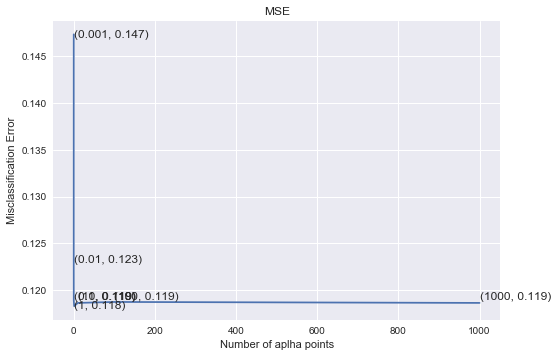

the misclassification error for each alpha is :  [ 0.147  0.123  0.119  0.118  0.119  0.119  0.119]


In [271]:
# plot misclassification error vs alpha 
plt.plot(C_Val, MSE_w2v)

for xy in zip(C_Val, np.round(MSE_w2v,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of aplha points')
plt.ylabel('Misclassification Error')
plt.title('MSE')
plt.show()

print("the misclassification error for each alpha is : ", np.round(MSE_w2v,3))

In [135]:
# instantiate learning model k = optimal_k
optimal_aplha_w2v=1
log_reg_optimal_w2v = LogisticRegression(C=optimal_aplha_w2v)

# fitting the model
log_reg_optimal_w2v.fit(X_tr_w2v, y_tr_w2v)

# predict the response
pred_w2v = log_reg_optimal_w2v.predict(X_test_w2v)

# evaluate accuracy
acc_w2v = accuracy_score(y_test_w2v, pred_w2v) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (optimal_aplha_w2v, acc_w2v))


The accuracy of the Logistic Regression for C = 1.000000 is 88.406667%


# GridSearch Avg W2V

In [273]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model_w2v_l2 = GridSearchCV(LogisticRegression(n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_w2v_l2.fit(X_tr_w2v, y_tr_w2v)
print(model_w2v_l2.best_estimator_)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [274]:
print(model_w2v_l2.score(X_test_w2v, y_test_w2v))

0.883666666667


In [275]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model_w2v_l1 = GridSearchCV(LogisticRegression(penalty='l1',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_w2v_l1.fit(X_tr_w2v, y_tr_w2v)
print(model_w2v_l1.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [276]:
print(model_w2v_l1.score(X_test_w2v, y_test_w2v))

0.883266666667


# RandomSearchCV Avg W2V

In [277]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
tuned_parameters = {'C': uniform.rvs(size=10)}
model_rand_l2_w2v = RandomizedSearchCV(LogisticRegression(n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_rand_l2_w2v.fit(X_tr_w2v, y_tr_w2v)
print(model_rand_l2_w2v.best_estimator_)

LogisticRegression(C=0.80559108708562166, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [278]:
print(model_rand_l2_w2v.score(X_test_w2v, y_test_w2v))

0.883566666667


In [279]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
tuned_parameters = {'C': uniform.rvs(size=10)}
model_rand_l1_w2v = RandomizedSearchCV(LogisticRegression(penalty='l1',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_rand_l1_w2v.fit(X_tr_w2v, y_tr_w2v)
print(model_rand_l1_w2v.best_estimator_)

LogisticRegression(C=0.91760039713185504, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [280]:
print(model_rand_l1_w2v.score(X_test_w2v, y_test_w2v))

0.883533333333


#  Sparsity with L1 Avg W2V

In [282]:
import numpy as np

clf_1_w2v = LogisticRegression(C=0.1, penalty='l1');
clf_1_w2v.fit(X_tr_w2v, y_tr_w2v);
print('acc',clf_1_w2v.score(X_test_w2v,y_test_w2v))
w_1_w2v = clf_1_w2v.coef_
print('sparsity',np.count_nonzero(w_1_w2v))

acc 0.8842
sparsity 48


In [283]:
clf_2_w2v = LogisticRegression(C=1, penalty='l1');
clf_2_w2v.fit(X_tr_w2v, y_tr_w2v);
print('acc',clf_2_w2v.score(X_test_w2v,y_test_w2v))
w_2_w2v = clf_2_w2v.coef_
print('sparsity',np.count_nonzero(w_2_w2v))

acc 0.883333333333
sparsity 50


In [284]:
clf_3_w2v = LogisticRegression(C=100, penalty='l1');
clf_3_w2v.fit(X_tr_w2v, y_tr_w2v);
print('acc',clf_3_w2v.score(X_test_w2v,y_test_w2v))
w_3_w2v = clf_3_w2v.coef_
print('sparsity',np.count_nonzero(w_3_w2v))

acc 0.8837
sparsity 50


# Multicollinearity Avg W2V

In [285]:
# Adding Noise to the matrix
mu, sigma = 0, 0.1
s = np.random.normal(mu, sigma, 1)
print(s)

[ 0.05373827]


In [136]:
sent_vectors[0]

array([ 0.44188607, -0.11082012,  0.11923695, -0.39371548, -0.01757231,
        0.55770447,  0.31380234, -0.60181747, -0.10743466,  0.22502994,
       -0.59566127,  0.27098435,  0.04081101, -0.13775745, -0.5128596 ,
        0.75088135,  0.60063419,  0.54239213,  0.11818313, -0.58889848,
       -0.27934573,  0.1439522 ,  0.56386373,  1.11674491, -0.42911389,
        0.41811838,  0.67825835,  0.28803299,  0.35926605,  0.59986197,
       -0.63473861, -0.26303549,  0.0506224 ,  0.15325701, -0.05400344,
       -0.22297534,  0.11594248, -0.45334876,  0.15019477,  0.32380784,
       -0.48239108, -0.28310504,  0.344402  ,  0.96474976, -0.62155364,
       -0.29880266, -0.26324255,  0.32983154, -0.25016528, -1.00039061])

In [139]:
noise_vector_w2v = [i * 0.05373827 for i in sent_vectors] # adding noise to the vector

In [228]:
noise_vector_w2v[0]

array([ 0.02374619, -0.00595528,  0.00640759, -0.02115759, -0.00094431,
        0.02997007,  0.01686319, -0.03234063, -0.00577335,  0.01209272,
       -0.03200981,  0.01456223,  0.00219311, -0.00740285, -0.02756019,
        0.04035106,  0.03227704,  0.02914721,  0.00635096, -0.03164639,
       -0.01501156,  0.00773574,  0.03030106,  0.06001194, -0.02305984,
        0.02246896,  0.03644843,  0.01547839,  0.01930634,  0.03223554,
       -0.03410976, -0.01413507,  0.00272036,  0.00823577, -0.00290205,
       -0.01198231,  0.00623055, -0.02436218,  0.00807121,  0.01740087,
       -0.02592286, -0.01521358,  0.01850757,  0.05184398, -0.03340122,
       -0.01605714, -0.0141462 ,  0.01772458, -0.01344345, -0.05375926])

In [141]:
# split the data set into train and test
X_1_w2v_mul, X_test_w2v_mul, y_1_w2v_mul, y_test_w2v_mul = cross_validation.train_test_split(noise_vector_w2v, sample_labels, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr_w2v_mul, X_cv_w2v_mul, y_tr_w2v_mul, y_cv_w2v_mul = cross_validation.train_test_split(X_1_w2v_mul, y_1_w2v_mul, test_size=0.3)

In [142]:
# instantiate learning model k = optimal_k
optimal_aplha_w2v=1
log_reg_optimal_w2v_mul = LogisticRegression(C=optimal_aplha_w2v)

# fitting the model
log_reg_optimal_w2v_mul.fit(X_tr_w2v_mul, y_tr_w2v_mul)

# predict the response
pred_w2v_mul = log_reg_optimal_w2v_mul.predict(X_test_w2v_mul)

# evaluate accuracy
acc_w2v_mul = accuracy_score(y_test_w2v_mul, pred_w2v_mul) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (optimal_aplha_w2v, acc_w2v_mul))


The accuracy of the Logistic Regression for C = 1.000000 is 87.250000%


In [143]:
weight_multi_w2v = log_reg_optimal_w2v_mul.coef_ # weights with  noise
print(weight_multi_w2v.shape)
print(weight_multi_w2v)

(1, 50)
[[ -0.52946628   0.4325097    7.99115862   1.55398753   6.86266371
   11.31293541  -0.60481716  11.61001414  -6.80116669  12.6609681
    0.07297742   4.39949113   4.67354836  -8.18519988   1.7537636
   -5.13268185  -5.94731944   7.87460556  -6.29573609  -3.84760909
   -7.78393785  -0.44889409   2.80500272   8.96015192 -11.14312205
   -3.93184652 -14.29838931  -2.74497703   4.19137862   1.89534764
   -5.41071046   1.03903327  -6.41208814  -5.47661896  -8.04055982
   -7.05250795  -3.36681588 -10.79145235  -0.62962113  -6.65838344
   -9.65503403  -4.97194237  -7.37102992   8.97198237  -5.03058574
   -6.16988719  -4.72276893  14.56186151  14.19053535  -6.05073668]]


In [144]:
# Weights from the original matrix which is not added any noise
original_weights_w2v = log_reg_optimal_w2v.coef_ # original weights with no noise
print(original_weights_w2v.shape)
print(original_weights_w2v)

(1, 50)
[[-0.03579462 -0.63082425  1.06866886 -0.29352074  1.40347648  0.61565648
  -1.22930168  0.28273635 -1.66991331  1.17700618  0.19146611  0.09689499
   0.45792826 -1.01784316  1.33165397 -0.71172841 -0.2545565   1.1073005
  -0.61779611 -0.94173729 -0.08242883 -0.54201401  0.65707153  0.96581498
  -1.17252775 -0.95380022 -1.81057379  0.88824571  0.24305723  0.67671295
  -0.41579838  0.32646834 -0.16144522 -0.07150347 -0.51035837 -0.75892702
   0.46683699 -0.42670059  0.2004345  -1.32867807 -1.43807692 -0.74951363
   0.1768732   0.86734874 -1.05419953 -1.03278689 -0.850341    2.27049878
   0.85318335 -1.32756014]]


In [146]:
diffs_w2v = weight_multi_w2v - original_weights_w2v
print(diffs_w2v.flatten()[:20])

[ -0.49367167   1.06333394   6.92248976   1.84750827   5.45918723
  10.69727894   0.62448452  11.32727779  -5.13125337  11.48396192
  -0.11848869   4.30259614   4.21562011  -7.16735672   0.42210963
  -4.42095344  -5.69276294   6.76730506  -5.67793998  -2.9058718 ]


# Avg TF-IDF

In [223]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec = sent_vec + (vec * tfidf)
            weight_sum = weight_sum + tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [224]:
print(tfidf_sent_vectors[0])

[ 0.51174193 -0.31839725 -0.0983731  -0.45661953 -0.03104173  0.74640964
  0.37032675 -0.45300674  0.14048464  0.29848582 -0.66721124 -0.02924557
  0.06185449  0.01144127 -0.2198804   0.43754997  0.51305779  0.535481
 -0.05857565 -0.55156766 -0.19699542  0.32552092  0.49812863  1.05022886
 -0.46880077  0.13185008  0.45662794  0.01598062  0.22679811  0.54983921
 -0.51309875 -0.25350072  0.1427328   0.04749266  0.11206363 -0.06661182
  0.34600351 -0.37654656 -0.01306791  0.29597598 -0.46505005  0.03232198
  0.26106422  0.75008766 -0.62458911 -0.41358922 -0.1428284   0.49983785
 -0.08443853 -0.67937754]


In [225]:
print(len(tfidf_sent_vectors))

100000


# Train,CV,Test - AvgTF-IDF

In [226]:
# split the data set into train and test
X_1_avg_tf, X_test_avg_tf, y_1_avg_tf, y_test_avg_tf = cross_validation.train_test_split(tfidf_sent_vectors, sample_labels, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr_avg_tf, X_cv_avg_tf, y_tr_avg_tf, y_cv_avg_tf = cross_validation.train_test_split(X_1_avg_tf, y_1_avg_tf, test_size=0.3)

In [250]:
X_tr_avg_tf = pd.DataFrame(data=X_tr_avg_tf)
X_tr_avg_tf = X_tr_avg_tf.fillna(X_tr_avg_tf.mean())
print(X_tr_avg_tf.isnull().values.any())

False


In [251]:
C_Val = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_scores_avg_tf = []
for val in C_Val:
    Log_reg_avg_tf = LogisticRegression(C=val)
    scores_avg_tf = cross_val_score(Log_reg_avg_tf, X_tr_avg_tf, y_tr_avg_tf, cv=10, scoring='accuracy')
    cv_scores_avg_tf.append(scores_avg_tf.mean())
print(cv_scores_avg_tf)

[0.85916313381243659, 0.87159168044521618, 0.87259169298505967, 0.87340803201641626, 0.87332638270022933, 0.87330595787893794, 0.87328554554989135]


In [252]:
# changing to misclassification error
MSE_avg_tf = [1 - x for x in cv_scores_avg_tf]

# determining best k
optimal_aplha_avg_tf = C_Val[MSE_avg_tf.index(min(MSE_avg_tf))]
print('\nThe optimal number of alpha is %d.' % optimal_aplha_avg_tf)


The optimal number of alpha is 1.


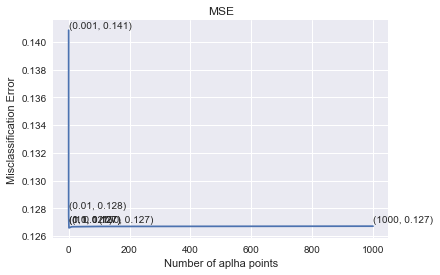

the misclassification error for each alpha is :  [ 0.141  0.128  0.127  0.127  0.127  0.127  0.127]


In [253]:
# plot misclassification error vs alpha 
plt.plot(C_Val, MSE_avg_tf)

for xy in zip(C_Val, np.round(MSE_avg_tf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of aplha points')
plt.ylabel('Misclassification Error')
plt.title('MSE')
plt.show()

print("the misclassification error for each alpha is : ", np.round(MSE_avg_tf,3))

In [255]:
# instantiate learning model k = optimal_k
optimal_aplha_avg_tf=1
log_reg_optimal_avg_tf = LogisticRegression(C=optimal_aplha_avg_tf)

# fitting the model
log_reg_optimal_avg_tf.fit(X_tr_avg_tf, y_tr_avg_tf)

# predict the response
pred_avg_tf = log_reg_optimal_avg_tf.predict(X_test_avg_tf)

# evaluate accuracy
acc_avg_tf = accuracy_score(y_test_avg_tf, pred_avg_tf) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (optimal_aplha_avg_tf, acc_avg_tf))


The accuracy of the Logistic Regression for C = 1.000000 is 87.513333%


# GridSearch Avg TF-IDF

In [256]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model_avg_tf_l2 = GridSearchCV(LogisticRegression(n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_avg_tf_l2.fit(X_tr_avg_tf, y_tr_avg_tf)
print(model_avg_tf_l2.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [257]:
print(model_avg_tf_l2.score(X_test_avg_tf, y_test_avg_tf))

0.875133333333


In [260]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model_avg_tf_l1 = GridSearchCV(LogisticRegression(penalty='l1',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_avg_tf_l1.fit(X_tr_avg_tf, y_tr_avg_tf)
print(model_avg_tf_l1.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [261]:
print(model_avg_tf_l1.score(X_test_avg_tf, y_test_avg_tf))

0.875133333333


# RandomSearchCV AVG TF-IDF

In [263]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
tuned_parameters = {'C': uniform.rvs(size=10)}
model_rand_l2_avg_tf = RandomizedSearchCV(LogisticRegression(n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_rand_l2_avg_tf.fit(X_tr_avg_tf, y_tr_avg_tf)
print(model_rand_l2_avg_tf.best_estimator_)

LogisticRegression(C=0.90660872776219958, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [264]:
print(model_rand_l2_avg_tf.score(X_test_avg_tf, y_test_avg_tf))

0.8751


In [266]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
tuned_parameters = {'C': uniform.rvs(size=10)}
model_rand_l1_avg_tf = RandomizedSearchCV(LogisticRegression(penalty='l1',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_rand_l1_avg_tf.fit(X_tr_avg_tf, y_tr_avg_tf)
print(model_rand_l1_avg_tf.best_estimator_)

LogisticRegression(C=0.92224403068218885, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [267]:
print(model_rand_l1_avg_tf.score(X_test_avg_tf, y_test_avg_tf))

0.875033333333


# Sparsity with L1 Avg TF-IDF

In [269]:
import numpy as np

clf_1_avg_tf = LogisticRegression(C=0.1, penalty='l1');
clf_1_avg_tf.fit(X_tr_avg_tf, y_tr_avg_tf);
print('acc',clf_1_avg_tf.score(X_test_avg_tf,y_test_avg_tf))
w_1_avg_tf = clf_1_avg_tf.coef_
print('sparsity',np.count_nonzero(w_1_avg_tf))

acc 0.875166666667
sparsity 49


In [271]:
import numpy as np

clf_2_avg_tf = LogisticRegression(C=1, penalty='l1');
clf_2_avg_tf.fit(X_tr_avg_tf, y_tr_avg_tf);
print('acc',clf_2_avg_tf.score(X_test_avg_tf,y_test_avg_tf))
w_2_avg_tf = clf_2_avg_tf.coef_
print('sparsity',np.count_nonzero(w_2_avg_tf))

acc 0.8751
sparsity 50


In [272]:
import numpy as np

clf_3_avg_tf = LogisticRegression(C=100, penalty='l1');
clf_3_avg_tf.fit(X_tr_avg_tf, y_tr_avg_tf);
print('acc',clf_3_avg_tf.score(X_test_avg_tf,y_test_avg_tf))
w_3_avg_tf = clf_3_avg_tf.coef_
print('sparsity',np.count_nonzero(w_3_avg_tf))

acc 0.874633333333
sparsity 50


# Multicollinearity Avg TF-IDF

In [274]:
# Adding Noise to the matrix
mu, sigma = 0, 0.1
s = np.random.normal(mu, sigma, 1)
print(s)

[ 0.0989487]


In [275]:
noise_vector_avg_tf = [i * 0.05373827 for i in tfidf_sent_vectors] # adding noise to the vector

In [276]:
# split the data set into train and test
X_1_avg_tf_mul, X_test_avg_tf_mul, y_1_avg_tf_mul, y_test_avg_tf_mul = cross_validation.train_test_split(noise_vector_avg_tf, sample_labels, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr_avg_tf_mul, X_cv_avg_tf_mul, y_tr_avg_tf_mul, y_cv_avg_tf_mul = cross_validation.train_test_split(X_1_avg_tf_mul, y_1_avg_tf_mul, test_size=0.3)


In [278]:
X_tr_avg_tf_mul = pd.DataFrame(data=X_tr_avg_tf_mul)
X_tr_avg_tf_mul = X_tr_avg_tf_mul.fillna(X_tr_avg_tf_mul.mean())
print(X_tr_avg_tf_mul.isnull().values.any())

False


In [279]:
# instantiate learning model k = optimal_k
optimal_aplha_avg_tf=1
log_reg_optimal_avg_tf_mul = LogisticRegression(C=optimal_aplha_avg_tf)

# fitting the model
log_reg_optimal_avg_tf_mul.fit(X_tr_avg_tf_mul, y_tr_avg_tf_mul)

# predict the response
pred_avg_tf_mul = log_reg_optimal_avg_tf_mul.predict(X_test_avg_tf_mul)

# evaluate accuracy
acc_avg_tf_mul = accuracy_score(y_test_avg_tf_mul, pred_avg_tf_mul) * 100
print('\nThe accuracy of the Logistic Regression for C = %f is %f%%' % (optimal_aplha_avg_tf, acc_avg_tf_mul))


The accuracy of the Logistic Regression for C = 1.000000 is 86.883333%


In [281]:
weight_multi_avg_tf = log_reg_optimal_avg_tf_mul.coef_ # weights with  noise
print(weight_multi_avg_tf.shape)
print(weight_multi_avg_tf)

(1, 50)
[[ -1.19565116   0.41103293   7.06564944   0.81493603   4.09574637
    8.3037898   -0.62326072   9.04790841  -4.84543772  12.82962211
   -0.3542967    2.34126327   5.24958626  -6.44254015   3.92103852
   -5.31366544  -6.31757029   5.59002471  -5.46454393  -3.67195957
   -5.5860038    0.75604886   3.48335462   5.6910924   -9.00270042
   -2.88634042 -11.47374511  -2.0065696    3.0168884    1.35561793
   -5.11312785   0.83582565  -4.42825096  -4.3416799   -7.86835189
   -4.25957792  -2.57486799  -8.77514814   0.90481247  -5.15872323
   -7.36369565  -3.53351386  -7.10148978   6.70523092  -2.65867674
   -5.36206246  -4.50533019  13.01652552  11.6936484   -7.60582925]]


In [282]:
# Weights from the original matrix which is not added any noise
original_weights_avg_tf = log_reg_optimal_avg_tf.coef_ # original weights with no noise
print(original_weights_avg_tf.shape)
print(original_weights_avg_tf)

(1, 50)
[[-0.35042208 -0.76886267  0.74715693 -0.38517252  1.19609365  0.17724906
  -1.31677478 -0.14080108 -1.4031288   0.88528776  0.07660364 -0.46738738
   0.48238135 -0.89823943  2.21907947 -0.62050105 -0.05171797  1.03358181
  -0.48203131 -1.35859216 -0.05002123 -0.57944756  0.62722423  1.08151499
  -0.56132151 -1.00326308 -0.84906387  0.97961423  0.51344209  0.1636517
  -0.43314184  0.57898731  0.3104145   0.4595395  -0.56819258 -0.29638326
   0.85111512  0.01564376  0.45161809 -1.16639902 -0.82420767 -0.01403417
   0.71379222  0.7425713  -0.90477033 -0.62315891 -0.97662008  1.85285493
   0.50334442 -1.47846186]]


In [283]:
diffs_avg_tf = weight_multi_avg_tf - original_weights_avg_tf
print(diffs_avg_tf.flatten()[:20])

[ -0.84522908   1.1798956    6.31849251   1.20010855   2.89965272
   8.12654075   0.69351406   9.1887095   -3.44230892  11.94433436
  -0.43090034   2.80865065   4.76720491  -5.54430072   1.70195905
  -4.69316439  -6.26585231   4.5564429   -4.98251261  -2.31336741]
